In [1]:
# import os
# from os import path as pt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pandas as pd

from lib.load_dataset import get_dataset_with_time
from lib.networks.discriminator import Discriminator
from lib.networks.generator import Generator
from lib.trainers.train_discriminator import train_discriminator_step
from lib.trainers.train_generator import (
    generate_noise_with_time,
    train_generator_step,
)
from lib.utils import to_numpy

In [2]:
# Initialize
n_lags = 10

In [3]:
# Load and prepare dataset. We have already applied augmented
# the price with time and applied the rolling window
x_real_rolled_train, x_real_rolled_test, scalar, initial_prices, normalized_time = (
    get_dataset_with_time(["AAL"], 20)
)
x_real_rolled_train = x_real_rolled_train.to(device)
x_real_rolled_test = x_real_rolled_test.to(device)

normalized_time = normalized_time.to(device)

In [4]:
feature_dim = x_real_rolled_train.shape[-1]

In [5]:
train_dataset = TensorDataset(x_real_rolled_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
generator = Generator(feature_dim, 2, 256, 6, 8, device=device)
discriminator = Discriminator(feature_dim, 256, 6, 8, device=device)

In [7]:
# Loss function
# Binary Cross Entropy
criterion = nn.BCELoss()
# def compute_gradient_penalty(critic, real_data, fake_data, device):
#     """Calculates the gradient penalty loss for WGAN-GP"""
#     batch_size = real_data.size(0)
#     alpha = torch.rand(batch_size, 1, 1, device=device).expand_as(real_data)
#     interpolated = alpha * real_data + (1 - alpha) * fake_data
#     interpolated.requires_grad_(True)
#     critic_output = critic(interpolated)
#     gradients = torch.autograd.grad(
#         outputs=critic_output, inputs=interpolated,
#         grad_outputs=torch.ones(critic_output.size(), device=device),
#         create_graph=True, retain_graph=True, only_inputs=True)[0]
#     gradients = gradients.view(batch_size, -1)
#     gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
#     return gradient_penalty

# def critic_loss(critic, real_data, fake_data, device, lambda_gp=10):
#     real_scores = critic(real_data)
#     fake_scores = critic(fake_data)
#     loss = fake_scores.mean() - real_scores.mean()
#     gp = compute_gradient_penalty(critic, real_data, fake_data, device)
#     loss += lambda_gp * gp
#     return loss

# def generator_loss(critic, fake_data):
#     return -critic(fake_data).mean()

In [31]:
generator_optimizer = optim.Adam(generator.parameters(), lr=0.01)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.01)

In [32]:
num_epochs = 2

generator_losses = []
discriminator_losses = []
synthetic_data = []

In [33]:
best_loss = float("inf")
patience = 5
trigger_times = 0

# Training loop
for epoch in range(num_epochs):
    for i, real_data in enumerate(train_loader):
        real_data = real_data[0].to(device).float()
        noise = generate_noise_with_time(real_data, device)

        # Generate fake data, train generator and discriminator
        x_fake, g_loss = train_generator_step(
            generator, discriminator, noise, criterion, generator_optimizer, device
        )

        d_loss = train_discriminator_step(
            discriminator, real_data, x_fake, criterion, discriminator_optimizer, device
        )

        # Monitor progress
        if i % 10 == 0:  # Adjust based on your preference
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}"
            )
            if d_loss < best_loss:
                best_loss = d_loss
                trigger_times = 0  # reset the trigger
                # save_model(generator, discriminator)  # save the best model
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("Early stopping!")
                    break
        generator_losses.append(g_loss)
        discriminator_losses.append(d_loss)
        synthetic_data.append(x_fake.detach())

        if trigger_times >= patience:
            break


# best_loss = float('inf')
# patience = 5
# trigger_times = 0
# critic_updates_per_generator_update = 5

# # Training loop
# for epoch in range(num_epochs):
#     for i, real_data in enumerate(train_loader):
#         real_data = real_data[0].to(device).float()

#         for _ in range(critic_updates_per_generator_update):

#             noise = generate_noise_with_time(real_data, device)
#             x_fake = generator(noise)

#         # Generate fake data, train generator and discriminator
#             d_loss = critic_loss(discriminator, real_data, x_fake.detach(), device)
#             discriminator_optimizer.zero_grad()
#             d_loss.backward()
#             discriminator_optimizer.step()
#         # x_fake, g_loss = train_generator_step(generator, discriminator, noise, criterion, generator_optimizer, device)

#         # d_loss = train_discriminator_step(discriminator, real_data, x_fake, criterion, discriminator_optimizer, device)


#         noise = generate_noise_with_time(real_data, device)
#         x_fake = generator(noise)
#         g_loss = generator_loss(discriminator, x_fake)
#         generator_optimizer.zero_grad()
#         g_loss.backward()
#         generator_optimizer.step()

#         # Monitor progress
#         if i % 10 == 0:  # Adjust based on your preference
#             print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")
#             if d_loss < best_loss:
#                 best_loss = d_loss
#                 trigger_times = 0  # reset the trigger
#                 # save_model(generator, discriminator)  # save the best model
#             else:
#                 trigger_times += 1
#                 if trigger_times >= patience:
#                     print("Early stopping!")
#                     break


#         if trigger_times >= patience:
#             break


# class GANTrainer:
#     def __init__(self, generator, discriminator, generator_optimizer, discriminator_optimizer, device, num_epochs, train_loader, patience=5, critic_updates_per_generator_update=5):
#         self.generator = generator
#         self.discriminator = discriminator
#         self.g_opt = generator_optimizer
#         self.d_opt = discriminator_optimizer
#         self.device = device
#         self.num_epochs = num_epochs
#         self.train_loader = train_loader
#         self.patience = patience
#         self.critic_updates_per_generator_update = critic_updates_per_generator_update
#         self.best_loss = float('inf')
#         self.trigger_times = 0

#     def run_training_loop(self):
#         for epoch in range(self.num_epochs):
#             for i, real_data in enumerate(self.train_loader):
#                 real_data = real_data[0].to(self.device).float()

#                 # Update discriminator more frequently
#                 for _ in range(self.critic_updates_per_generator_update):
#                     noise = generate_noise_with_time(real_data, self.device)
#                     fake_data = self.generator(noise)
#                     d_loss = self.train_discriminator(real_data, fake_data.detach())

#                 # Update generator
#                 noise = generate_noise_with_time(real_data, self.device)
#                 fake_data = self.generator(noise)
#                 g_loss = self.train_generator(fake_data)

#                 # Monitor and display progress
#                 if i % 10 == 0:
#                     self.monitor_progress(epoch, i, g_loss, d_loss)

#                 if self.trigger_times >= self.patience:
#                     print("Early stopping!")
#                     return

#     def train_discriminator(self, real_data, fake_data):
#         self.d_opt.zero_grad()
#         loss = critic_loss(self.discriminator, real_data, fake_data, self.device)
#         loss.backward()
#         self.d_opt.step()
#         return loss.item()

#     def train_generator(self, fake_data):
#         self.g_opt.zero_grad()
#         loss = generator_loss(self.discriminator, fake_data)
#         loss.backward()
#         self.g_opt.step()
#         return loss.item()

#     def monitor_progress(self, epoch, batch_idx, g_loss, d_loss):
#         print(f"Epoch [{epoch+1}/{self.num_epochs}], Batch [{batch_idx+1}/{len(self.train_loader)}], Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")
#         if d_loss < self.best_loss:
#             self.best_loss = d_loss
#             self.trigger_times = 0  # Reset the patience trigger
#             # save_model(self.generator, self.discriminator)  # Optionally save the best model
#         else:
#             self.trigger_times += 1

# # Example usage
# trainer = GANTrainer(generator, discriminator, generator_optimizer, discriminator_optimizer, device, num_epochs, train_loader)
# trainer.run_training_loop()

Epoch [1/2], Batch [1/96], Generator Loss: 0.0004, Discriminator Loss: 8.0227
Epoch [1/2], Batch [11/96], Generator Loss: 0.8478, Discriminator Loss: 1.4093
Epoch [1/2], Batch [21/96], Generator Loss: 0.6185, Discriminator Loss: 1.4533
Epoch [1/2], Batch [31/96], Generator Loss: 0.7757, Discriminator Loss: 1.3954
Epoch [1/2], Batch [41/96], Generator Loss: 0.7408, Discriminator Loss: 1.3854
Epoch [1/2], Batch [51/96], Generator Loss: 0.6721, Discriminator Loss: 1.3947
Epoch [1/2], Batch [61/96], Generator Loss: 0.7497, Discriminator Loss: 1.3786
Epoch [1/2], Batch [71/96], Generator Loss: 0.6675, Discriminator Loss: 1.3980
Epoch [1/2], Batch [81/96], Generator Loss: 0.7128, Discriminator Loss: 1.3775
Epoch [1/2], Batch [91/96], Generator Loss: 0.7044, Discriminator Loss: 1.4233
Epoch [2/2], Batch [1/96], Generator Loss: 0.6645, Discriminator Loss: 1.4040
Epoch [2/2], Batch [11/96], Generator Loss: 0.7022, Discriminator Loss: 1.4194
Epoch [2/2], Batch [21/96], Generator Loss: 0.6858, Di

In [34]:
sequence_length = normalized_time.size(0)
noise = torch.randn(1, sequence_length, 1, device=device)
# noise = torch.tanh(noise)  # Scales the noise to be between -1 and 1

# Ensure normalized_time is properly shaped for concatenation
normalized_time_1 = normalized_time.view(1, sequence_length, 1)

# Concatenate normalized time and noise along the feature dimension
noise_with_time = torch.cat((normalized_time_1, noise), dim=2)

In [35]:
with torch.no_grad():  # Ensure no gradients are computed
    generator.eval()  # Set the generator to evaluation mode
    synthetic_log_returns = generator(noise_with_time)

synthetic_log_returns = synthetic_log_returns.squeeze(0)[:, 0]

In [36]:
synthetic_log_returns

tensor([10.5457, 10.5457, 10.5457,  ..., 10.5457, 10.5457, 10.5457])

In [16]:
noise_with_time[:, 0, :]

tensor([[ 0.0000, -0.3318]])

In [17]:
generator(noise_with_time[:, 0, :].unsqueeze(1))

tensor([[[-0.2460, -0.1616]]], grad_fn=<TransposeBackward0>)

In [38]:
generator(torch.tensor([[00, 0.3943]]).unsqueeze(1))

tensor([[[10.5457, 13.3473]]], grad_fn=<TransposeBackward0>)

In [70]:
noise_with_time[:, 2, :]

tensor([[0.0005, 0.4542]])

In [27]:
generator(noise_with_time[:, 1000, :].unsqueeze(1))

tensor([[[-0.2460, -0.1616]]], grad_fn=<TransposeBackward0>)

In [20]:
def reconstruct_prices_from_log_returns(initial_price, log_returns):
    """
    Reconstruct price series from log returns starting from an initial price.

    Args:
        initial_price (float): The initial price of the stock.
        log_returns (torch.Tensor): Synthetic log returns.

    Returns:
        np.ndarray: Reconstructed price series.
    """
    cumulative_log_returns = torch.cumsum(log_returns, dim=0)
    price_factors = torch.exp(cumulative_log_returns).numpy()
    prices = initial_price * price_factors
    return prices

In [18]:
initial_prices

array([18.19490623])

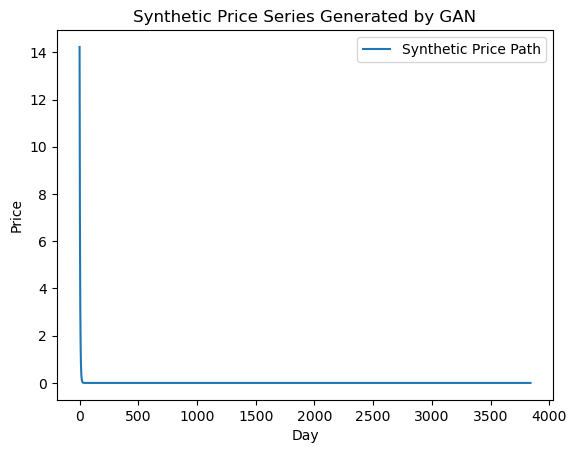

In [21]:
synthetic_prices = reconstruct_prices_from_log_returns(
    initial_prices, synthetic_log_returns
)

# Optionally, plot the synthetic price series
plt.plot(synthetic_prices, label="Synthetic Price Path")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Synthetic Price Series Generated by GAN")
plt.legend()
plt.show()

In [23]:
real_stocks = pd.read_csv("./data/stocks_data.csv")["AAL"].values

In [24]:
real_stocks.shape

(3842,)

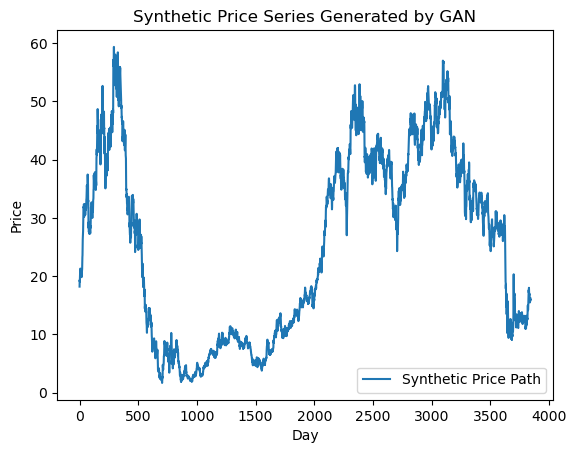

In [25]:
# Optionally, plot the synthetic price series
plt.plot(real_stocks, label="Synthetic Price Path")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Synthetic Price Series Generated by GAN")
plt.legend()
plt.show()

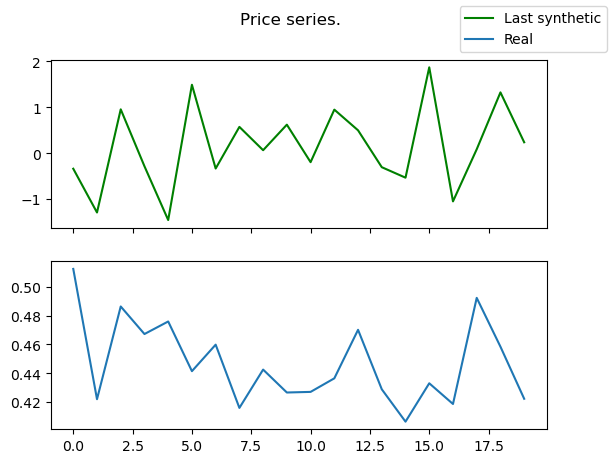

In [26]:
fig, axs = plt.subplots(2, sharex=True, sharey=False)
fig.suptitle("Price series.")
axs[0].plot(to_numpy(synthetic_data[-1][0][:, 1]), color="g", label="Last synthetic")
axs[1].plot(x_real_rolled_train[0][:, 1], label="Real")
fig.legend()

for ax in axs:
    ax.label_outer()